In [189]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import random
import tifffile as tiff
import tensorflow_io as tfio  # Needed for multispectral .tif
from PIL import Image
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [190]:
train_img_dir = "/kaggle/input/floods-dataset/data/images"
train_mask_dir = "/kaggle/input/floods-dataset/data/labels"
combined_mask_dir = "./combined_masks"

In [191]:
def display_image_and_mask(img_path, mask_path):
    # Load multispectral image & mask
    img = tiff.imread(img_path)
    mask = np.array(Image.open(mask_path))

    print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")

    # Make RGB composite — adjust channels if needed!
    rgb_img = img[:, :, [2, 1, 0]]  # Example: BGR order

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(rgb_img)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Combined Mask')
    axes[1].axis('off')

    plt.show()

    print("Unique mask labels:", np.unique(mask))

In [192]:
def combine_masks(mask_dir, mask_files, shape):
    combined = np.zeros(shape, dtype=np.uint8)
    for f in mask_files:
        if "_" in f:
            continue
        mask = np.array(Image.open(os.path.join(mask_dir, f)))
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        combined = np.maximum(combined, mask)
    combined = (combined > 0).astype(np.uint8)  # ensure binary
    return combined

In [193]:
# 1) Find base image names
image_basenames = sorted([os.path.splitext(f)[0] for f in os.listdir(train_img_dir) if f.endswith('.tif')])

# 2) For each image, find matching mask files
pairs = []
for basename in image_basenames:
    mask_files = [f for f in os.listdir(train_mask_dir) if f.startswith(basename) and f.endswith('.png')]
    if mask_files:
        pairs.append((basename + '.tif', mask_files))
    else:
        print(f"⚠️  Warning: No masks found for {basename}")

print(f"✅ Found {len(pairs)} valid image–mask pairs.")

# 3) Combine & save
os.makedirs(combined_mask_dir, exist_ok=True)

for img_file, mask_list in pairs:
    img = tiff.imread(os.path.join(train_img_dir, img_file))
    h, w = img.shape[:2]

    combined_mask = combine_masks(train_mask_dir, mask_list, shape=(h, w))

    combined_mask_path = os.path.join(combined_mask_dir, os.path.splitext(img_file)[0] + "_combined.png")
    Image.fromarray(combined_mask).save(combined_mask_path)

print(f"✅ Combined masks saved in: {combined_mask_dir}")

✅ Found 306 valid image–mask pairs.
✅ Combined masks saved in: ./combined_masks


Image shape: (128, 128, 12)


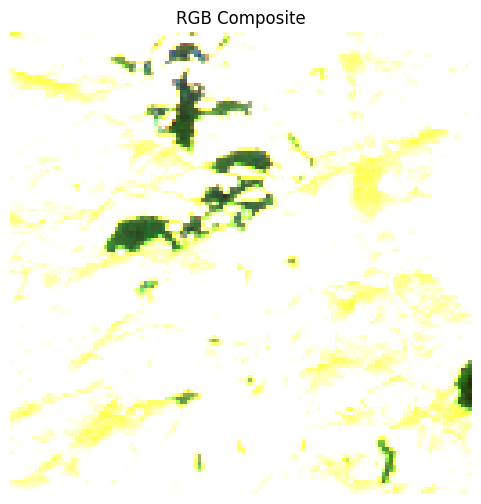

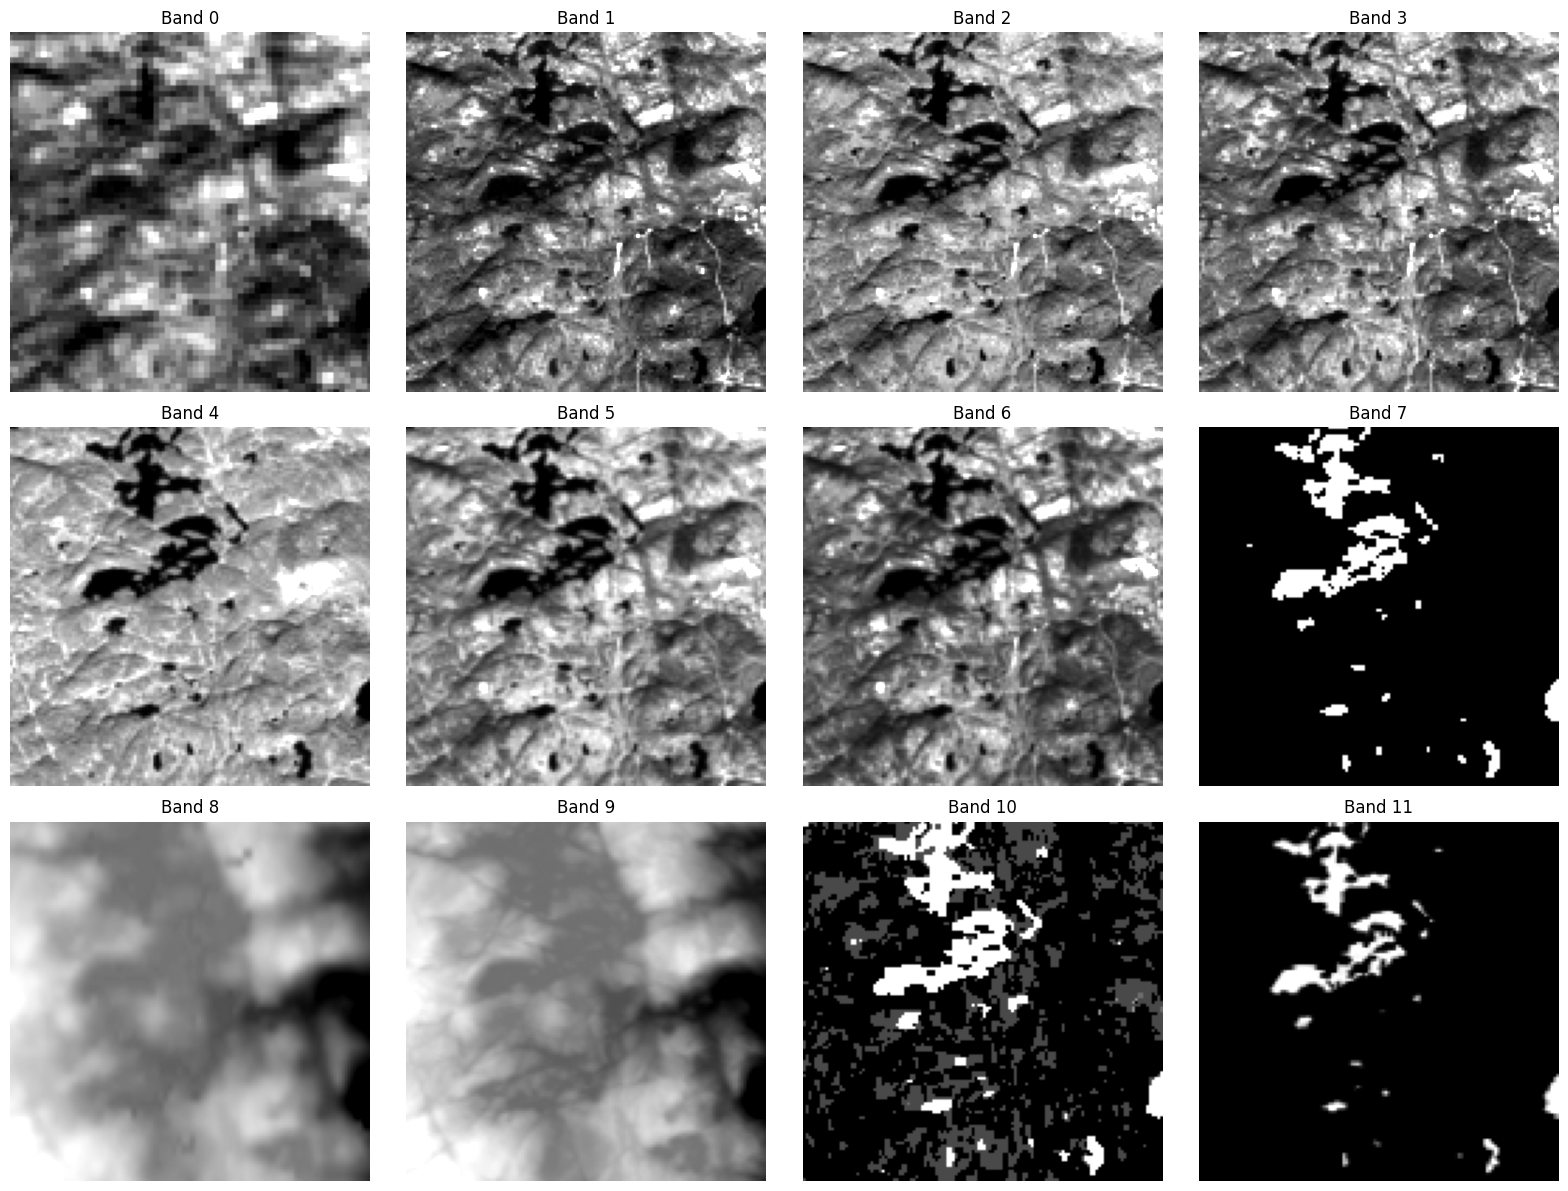

In [194]:
# INSPECT RGB + BANDS
# ============================

# Pick an image
img_file = pairs[0][0]
img_path = os.path.join(train_img_dir, img_file)

img = tiff.imread(img_path)
print(f"Image shape: {img.shape}")

# RGB composite
rgb_bands = [5, 4, 3]  # Example: adjust if needed            # 3 2 1
rgb_img = img[:, :, rgb_bands]

plt.figure(figsize=(6, 6))
plt.imshow(rgb_img)
plt.title('RGB Composite')
plt.axis('off')
plt.show()

# All bands
n_bands = img.shape[2]
cols = 4
rows = (n_bands + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

for i in range(rows * cols):
    ax = axes.flat[i]
    if i < n_bands:
        band = img[:, :, i]
        vmin, vmax = np.percentile(band, [2, 98])
        ax.imshow(band, cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(f'Band {i}')
    else:
        ax.axis('off')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [195]:
# FINAL TRAIN/VAL SPLIT
# ============================

# Build final DataFrame using same pairs
images = [os.path.join(train_img_dir, img_file) for img_file, _ in pairs]
masks  = [os.path.join(combined_mask_dir, os.path.splitext(img_file)[0] + "_combined.png") for img_file, _ in pairs]

data = pd.DataFrame({"image": images, "mask": masks})

train_df, val_df = train_test_split(data, train_size=0.8, shuffle=True, random_state=123)

print(f"✅ Training: {len(train_df)}")
print(f"✅ Validation: {len(val_df)}")

train_df.head()

✅ Training: 244
✅ Validation: 62


,image,mask
203,/kaggle/input/floods-dataset/data/images/281.tif,./combined_masks/281_combined.png
232,/kaggle/input/floods-dataset/data/images/32.tif,./combined_masks/32_combined.png
35,/kaggle/input/floods-dataset/data/images/13.tif,./combined_masks/13_combined.png
249,/kaggle/input/floods-dataset/data/images/48.tif,./combined_masks/48_combined.png
161,/kaggle/input/floods-dataset/data/images/243.tif,./combined_masks/243_combined.png


Image shape: (128, 128, 12), Mask shape: (128, 128)


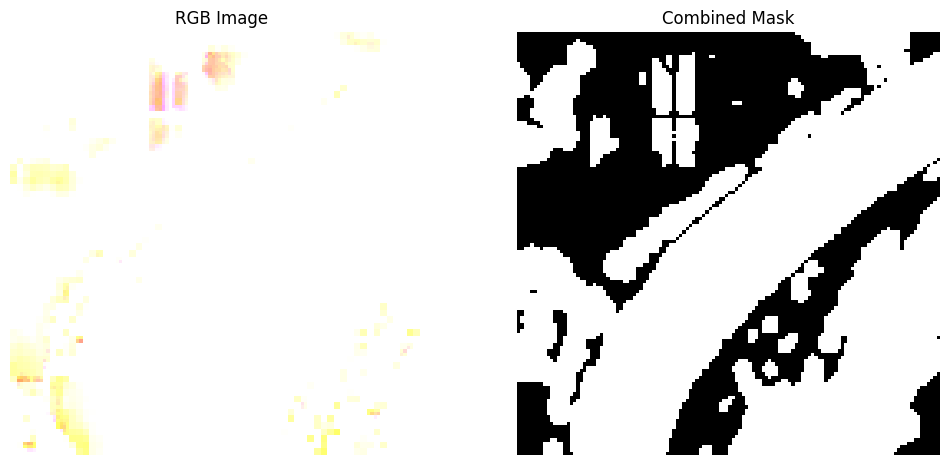

Unique mask labels: [0 1]
Image shape: (128, 128, 12), Mask shape: (128, 128)


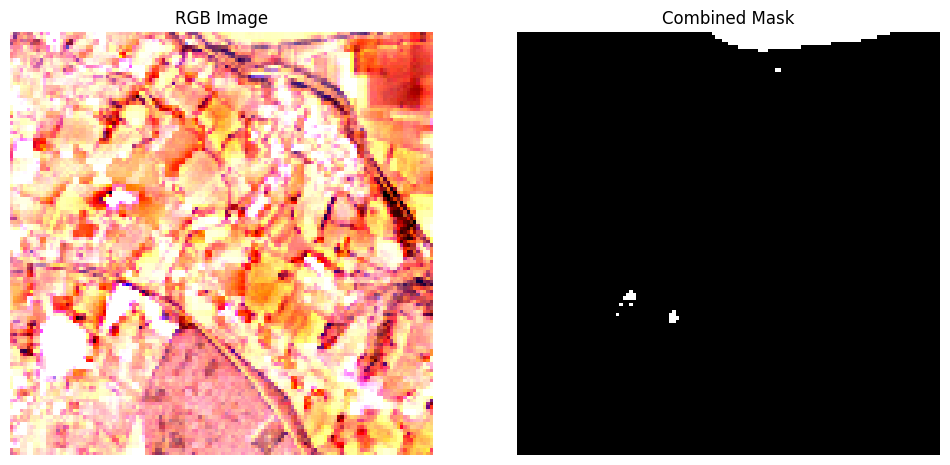

Unique mask labels: [0 1]
Image shape: (128, 128, 12), Mask shape: (128, 128)


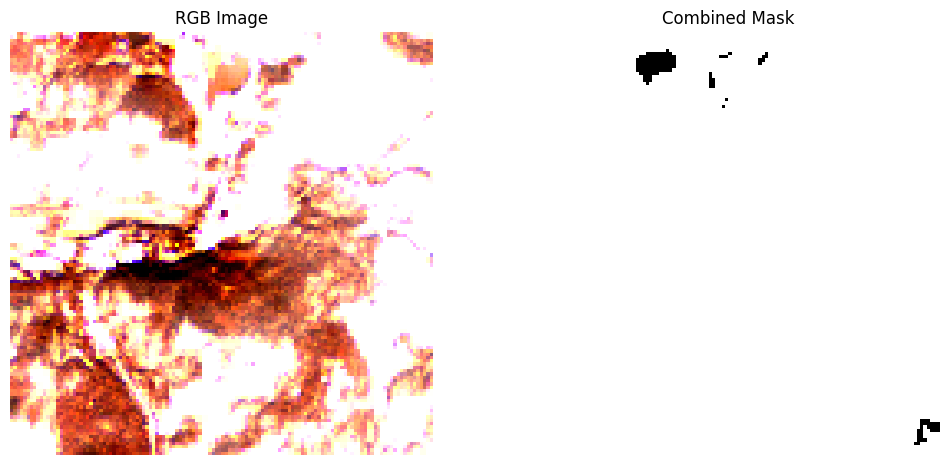

Unique mask labels: [0 1]
Image shape: (128, 128, 12), Mask shape: (128, 128)


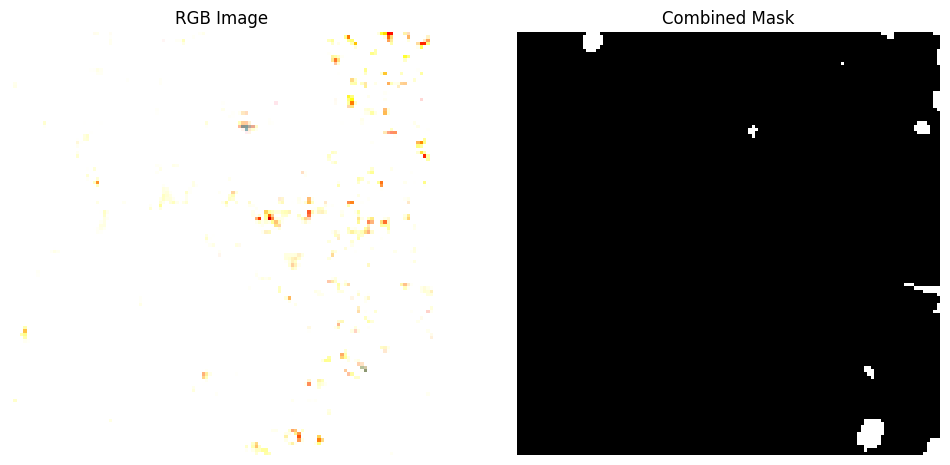

Unique mask labels: [0 1]
Image shape: (128, 128, 12), Mask shape: (128, 128)


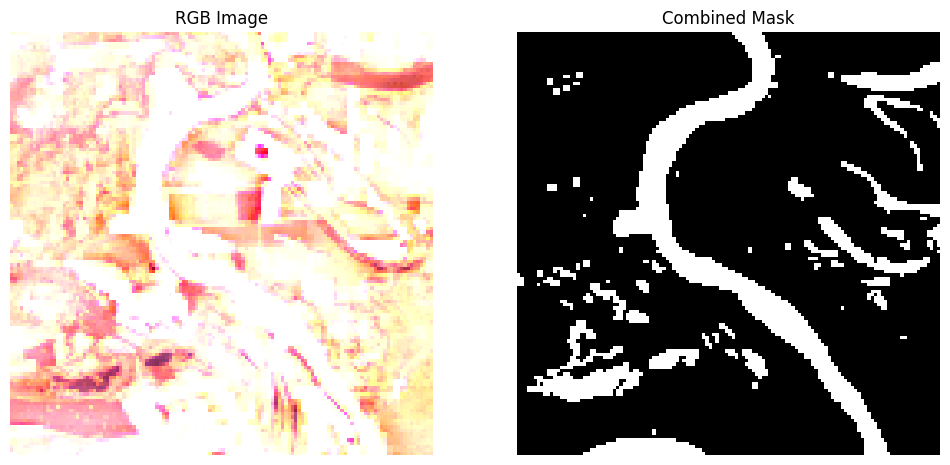

Unique mask labels: [0 1]


In [196]:
# Display a few to check
for i in range(5):
    display_image_and_mask(train_df.iloc[i]['image'], train_df.iloc[i]['mask'])

In [197]:
# === 1️⃣ Robust decode function ===
  # === Stretch contrast helper ===
def stretch_contrast(img):
    """
    Stretch each band to [0, 1] based on its 2nd and 98th percentiles.
    """
    stretched = np.zeros_like(img)
    for i in range(img.shape[-1]):
        band = img[:, :, i]
        p2, p98 = np.percentile(band, (2, 98))
        stretched[:, :, i] = np.clip((band - p2) / (p98 - p2 + 1e-5), 0, 1)
    return stretched

def decode_img(img_path, mask_path):  
    def _load(img_path, mask_path):
        try:
            img_path = img_path.decode()
            mask_path = mask_path.decode()
    
            # Load TIFF (H, W, C)
            img = tiff.imread(img_path).astype(np.float32)
            
            # ⚠️ IMPORTANT: If your model is multispectral, keep all bands!
            # If you want RGB only for testing: pick first 3.
            if img.shape[-1] >= 12:
                pass  # Keep all 12 bands
            elif img.shape[-1] >= 3:
                img = img[:, :, :3]
            else:
                raise ValueError(f"Unexpected channel count: {img.shape}")


             # ❌ Old shape: (H, W, 12)
            # ✅ Remove bands 8 and 9 (index 8 and 9)
            img = np.concatenate([img[..., :8], img[..., 10:]], axis=-1)  # Now (H, W, 10)

            # 👇 Apply percentile stretching here
            img = stretch_contrast(img)
    
            mask = np.array(Image.open(mask_path)).astype(np.uint8)
    
            return img, mask
        except Exception as e:
            print("❌ Failed to load or preprocess:", img_path, mask_path)
            print("Error:", e)
            return np.zeros((128, 128, 10), dtype=np.float32), np.zeros((128, 128), dtype=np.uint8)   

     

    img, mask = tf.numpy_function(_load, [img_path, mask_path], [tf.float32, tf.uint8])

    # 👉 For multispectral:
    img.set_shape([128,128, 10])  # Match your model input!
    mask.set_shape([128,128])     # Single channel

    # Resize with correct method
    img = tf.image.resize(img, [128, 128])
    mask = tf.image.resize(mask[..., tf.newaxis], [128, 128], method='nearest') #tf.squeeze(mask, axis=-1) simply removes that 1-channel dimension:
    mask =tf.squeeze(mask, axis=-1)                                                   #From: (128, 128, 1)
                                                                                #To: (128, 128)

    return img, mask

# === 2️⃣ Augmentation ===
def fun_augment(img, mask):
    flip_lr = tf.random.uniform(()) > 0.5
    img = tf.cond(flip_lr, lambda: tf.image.flip_left_right(img), lambda: img)
    mask = tf.cond(flip_lr, lambda: tf.image.flip_left_right(mask[..., tf.newaxis]), lambda: mask[..., tf.newaxis])

    flip_ud = tf.random.uniform(()) > 0.5
    img = tf.cond(flip_ud, lambda: tf.image.flip_up_down(img), lambda: img)
    mask = tf.cond(flip_ud, lambda: tf.image.flip_up_down(mask), lambda: mask)

    mask = tf.squeeze(mask, axis=-1)
    return img, mask
    
# === 3️⃣ Dataset factory ===
def prepare_dataset(img_paths, mask_paths, augment=False, shuffle=False, batch_size=8):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        ds = ds.map(fun_augment, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(512, seed=123)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [198]:
train_ds = prepare_dataset(
    train_df['image'].tolist(),
    train_df['mask'].tolist(),
    augment=True,
    shuffle=True,
    batch_size=8
)

val_ds = prepare_dataset(
    val_df['image'].tolist(),
    val_df['mask'].tolist(),
    augment=False,
    shuffle=False,
    batch_size=8
)

In [199]:
for image, mask in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)

Image shape: (8, 128, 128, 10)
Mask shape: (8, 128, 128)


In [200]:
# Compute pixel-level weights
from sklearn.utils import class_weight

# Step 1: Collect all ground truth pixels from masks
y_true_list = []

for images, masks in train_ds:
    y_true_list.append(masks.numpy())

# Step 2: Flatten into 1D array
all_masks = np.concatenate(y_true_list).flatten()

# Step 3: Compute balanced class weights (for binary: 0=background, 1=water)
class_weights_np = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_masks),
    y=all_masks
)

# Step 4: Convert to TensorFlow constant for use in the loss function
class_weights = tf.constant(class_weights_np, dtype=tf.float32)
print("✅ Class Weights:", class_weights.numpy())


✅ Class Weights: [0.73659724 1.5566479 ]


In [201]:
def fun_weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)  # shape: (batch, H, W)
    y_true_oh = tf.one_hot(y_true, depth=2)  # shape: (batch, H, W, 2)

    loss = tf.keras.losses.categorical_crossentropy(y_true_oh, y_pred)
    weights = tf.reduce_sum(class_weights * y_true_oh, axis=-1)  # pixel-wise weights
    return tf.reduce_mean(loss * weights)

In [202]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    loss = 1 - (numerator + smooth) / (denominator + smooth)
    return tf.reduce_mean(loss)

def combo_bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * d_loss

# PREtrained model with customization

In [206]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet101

def build_unet_resnet101_10bands(input_shape=(128, 128, 10), num_classes=2, freeze_encoder=True):
    # Input with 10 bands
    inputs = Input(shape=input_shape)

    # Project 10 bands to 3 channels
    x = layers.Conv2D(3, (1, 1), padding='same', activation='linear')(inputs)

    # Load ResNet101 base WITHOUT input_tensor
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

    # Extract skip connections
    skip1 = base_model.get_layer("conv1_relu").output           # 64x64
    skip2 = base_model.get_layer("conv2_block3_out").output     # 32x32
    skip3 = base_model.get_layer("conv3_block4_out").output     # 16x16
    skip4 = base_model.get_layer("conv4_block23_out").output    # 8x8
    encoder_output = base_model.get_layer("conv5_block3_out").output  # 4x4

    # Build encoder model
    encoder_model = models.Model(inputs=base_model.input, outputs=[skip1, skip2, skip3, skip4, encoder_output])

    if freeze_encoder:
        encoder_model.trainable = False
    else:
        encoder_model.trainable = True  # fine-tuning

    # Apply encoder to projected input
    s1, s2, s3, s4, bottleneck = encoder_model(x)

    # Decoder
    x = bottleneck
    for skip in [s4, s3, s2, s1]:  # reverse order
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    # Final layers
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


In [207]:
# ✅ Define MeanIoU correctly as a Keras metric
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)

In [208]:
unet_model = build_unet_resnet101_10bands(input_shape=(128, 128, 10), num_classes=2)

# Custom IoU
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name="mean_iou", **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=fun_weighted_loss,
    metrics=[CustomMeanIoU(num_classes=2)]
)


unet_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 128, 128,  │         33 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ [(None, 64, 64,   │ 42,658,176 │ conv2d_52[0][0]   │
│ (Functional)        │ 64), (None, 32,   │            │                   │
│                     │ 32, 256), (None,  │            │                   │
│                     │ 16, 16, 512),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 1024), (None, 4,  │            │                   │
│                     │ 4, 2048)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_30    │ (None, 8, 8,      │          0 │ functional_9[0][… │
│ (UpSampling2D)      │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 8, 8,      │          0 │ up_sampling2d_30… │
│ (Concatenate)       │ 3072)             │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 8, 8, 256) │  7,078,144 │ concatenate_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_31    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 16, 16,    │          0 │ up_sampling2d_31… │
│ (Concatenate)       │ 768)              │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 16, 16,    │  1,769,728 │ concatenate_25[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_32    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 32, 32,    │          0 │ up_sampling2d_32… │
│ (Concatenate)       │ 512)              │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 32, 32,    │  1,179,904 │ concatenate_26[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 53,723,427 (204.94 MB)

 Trainable params: 11,062,947 (42.20 MB)

 Non-trainable params: 42,660,480 (162.74 MB)

In [209]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_unet_model.h5',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),

     tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mean_iou',
        factor=0.5,
        patience=10,
        min_lr=1e-4,
        mode='max'
    )
]

In [210]:
history = unet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 1.0677 - mean_iou: 0.3489
Epoch 1: val_loss improved from inf to 5.68429, saving model to best_unet_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 61s 896ms/step - loss: 1.0602 - mean_iou: 0.3496 - val_loss: 5.6843 - val_mean_iou: 0.1923 - learning_rate: 0.0010
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.6528 - mean_iou: 0.4156
Epoch 2: val_loss improved from 5.68429 to 1.11882, saving model to best_unet_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - loss: 0.6523 - mean_iou: 0.4167 - val_loss: 1.1188 - val_mean_iou: 0.3901 - learning_rate: 0.0010
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.6856 - mean_iou: 0.4669
Epoch 3: val_loss did not improve from 1.11882
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.6844 - mean_iou: 0.4666 - val_loss: 1.6899 - val_mean_iou: 0.3615 - learning_rate: 0.0010
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.5958 - mean_iou: 0.4991
Epoch 4: val_lo

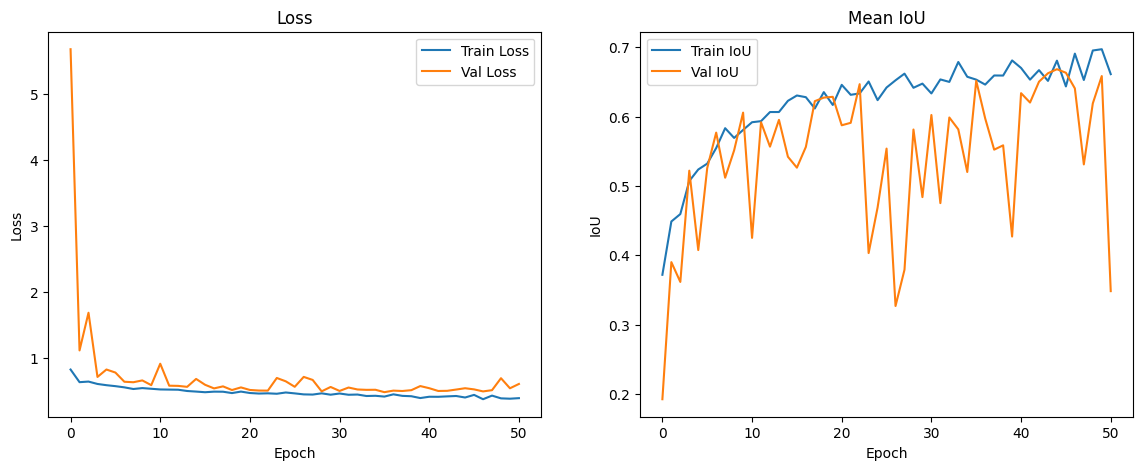

In [211]:
def plot_history(history):
    plt.figure(figsize=(14,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # IoU
    plt.subplot(1,2,2)
    plt.plot(history.history['mean_iou'], label='Train IoU')
    plt.plot(history.history['val_mean_iou'], label='Val IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.show()

plot_history(history)


In [212]:
# Evaluate
loss, miou = unet_model.evaluate(val_ds)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Mean IoU: {miou:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.4984 - mean_iou: 0.6194
Validation Loss: 0.4858
Validation Mean IoU: 0.6517


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def overlay_predictions(model, generator, alpha=0.5, num_images_to_show=3):
    images, masks_true = generator[0]
    predictions = model.predict(images)

    print(f"Displaying {min(num_images_to_show, len(images))} images from the batch.")

    for i in range(min(num_images_to_show, len(images))):
        plt.figure(figsize=(20, 7))

        # Show input image
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i][:, :, :3])


In [213]:
import cv2
import numpy as np

def postprocess_mask(pred_mask, min_size=100):
    """
    Removes small connected components (blobs) from binary mask.
    """
    pred_mask = (pred_mask == 1).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(pred_mask, connectivity=8)

    output = np.zeros_like(pred_mask)
    for i in range(1, num_labels):  # skip background
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 1
    return output

# Updated evaluation with post-processing
y_true_list = []
y_pred_list = []

for images, masks in val_ds:
    preds = unet_model.predict(images)
    preds = np.argmax(preds, axis=-1)  # shape: (batch, H, W)

    # Apply post-processing per image
    preds_cleaned = np.array([postprocess_mask(p) for p in preds])

    y_true_list.append(masks.numpy())        # shape: (batch, H, W)
    y_pred_list.append(preds_cleaned)        # shape: (batch, H, W)

# Flatten all batches
y_true_all = np.concatenate(y_true_list).flatten()
y_pred_all = np.concatenate(y_pred_list).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [214]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

print(conf_matrix)

[[582707  76860]
 [115890 240351]]


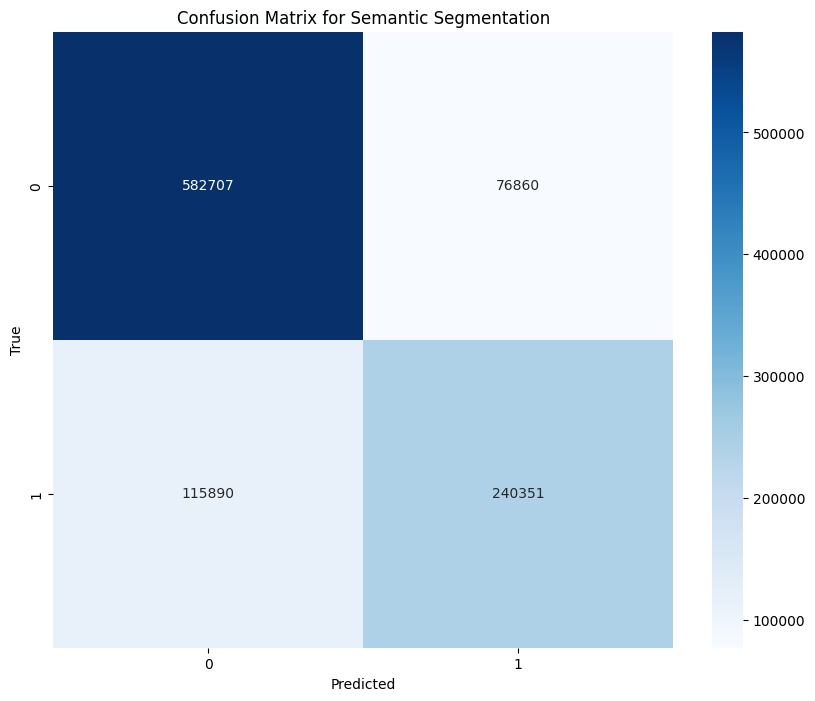

In [215]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Semantic Segmentation')
plt.show()
